In [2]:
!pip install roboflow
!pip install ultralytics
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00


In [3]:
from roboflow import Roboflow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import os
import cv2
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import yaml
from ultralytics import YOLO
from roboflow import Roboflow
import time
import glob
import csv

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.6/112.6 GB disk)


In [4]:
rf = Roboflow(api_key="xxx")
project = rf.workspace("xxx").project("xxx")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to HW4-1 in yolov8:: 100%|██████████| 141/141 [00:00<00:00, 6074.08it/s]


In [8]:
import yaml

with open('/content/HW4/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
    class_names = {i: name for i, name in enumerate(data['names'])}

class_names

{0: 'gloves', 1: 'helmet', 2: 'no-gloves', 3: 'no-helmet', 4: 'person'}

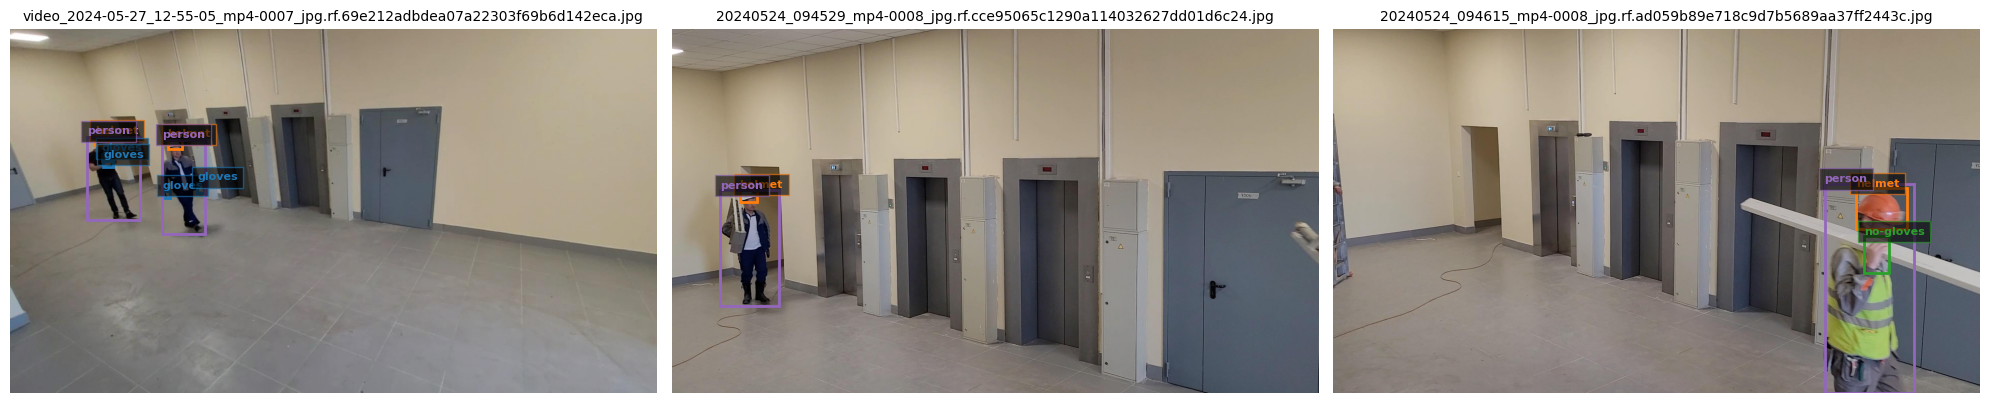

In [9]:
image_dir = os.path.join("/content/HW4/train", "images")
labels_dir = os.path.join("/content/HW4/train", "labels")

image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg'))][:3]

num_classes = len(class_names)
colors = cm.tab20(np.linspace(0, 1, max(num_classes, 10)))

fig, axes = plt.subplots(1, len(image_files), figsize=(20, 4))
if len(image_files) == 1:
    axes = [axes]

for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    img = mpimg.imread(img_path)
    h, w = img.shape[:2]

    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)

    ax = axes[idx]
    ax.imshow(img)
    ax.set_title(img_file, fontsize=10)
    ax.axis('off')

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])

                cx, cy, box_w, box_h = map(float, parts[1:5])

                x1 = (cx - box_w/2) * w
                y1 = (cy - box_h/2) * h
                x2 = (cx + box_w/2) * w
                y2 = (cy + box_h/2) * h

                color = colors[class_id % num_classes][:3]

                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                        linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                label_text = class_names.get(class_id, f'Class {class_id}')
                ax.text(x1, y1-5, label_text, color=color, fontsize=8, fontweight='bold',
                       bbox=dict(facecolor='black', alpha=0.6, edgecolor=color))

plt.tight_layout()
plt.show()

# YOLO v8s without augmentations

In [32]:
start = time.time()
!yolo task=detect mode=train model=yolov8s.pt data=/content/HW4/data.yaml epochs=50 imgsz=640 plots=True name=yolov8s_no_augmentations
train_time_yolov8s_no_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HW4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_no_augmentations4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

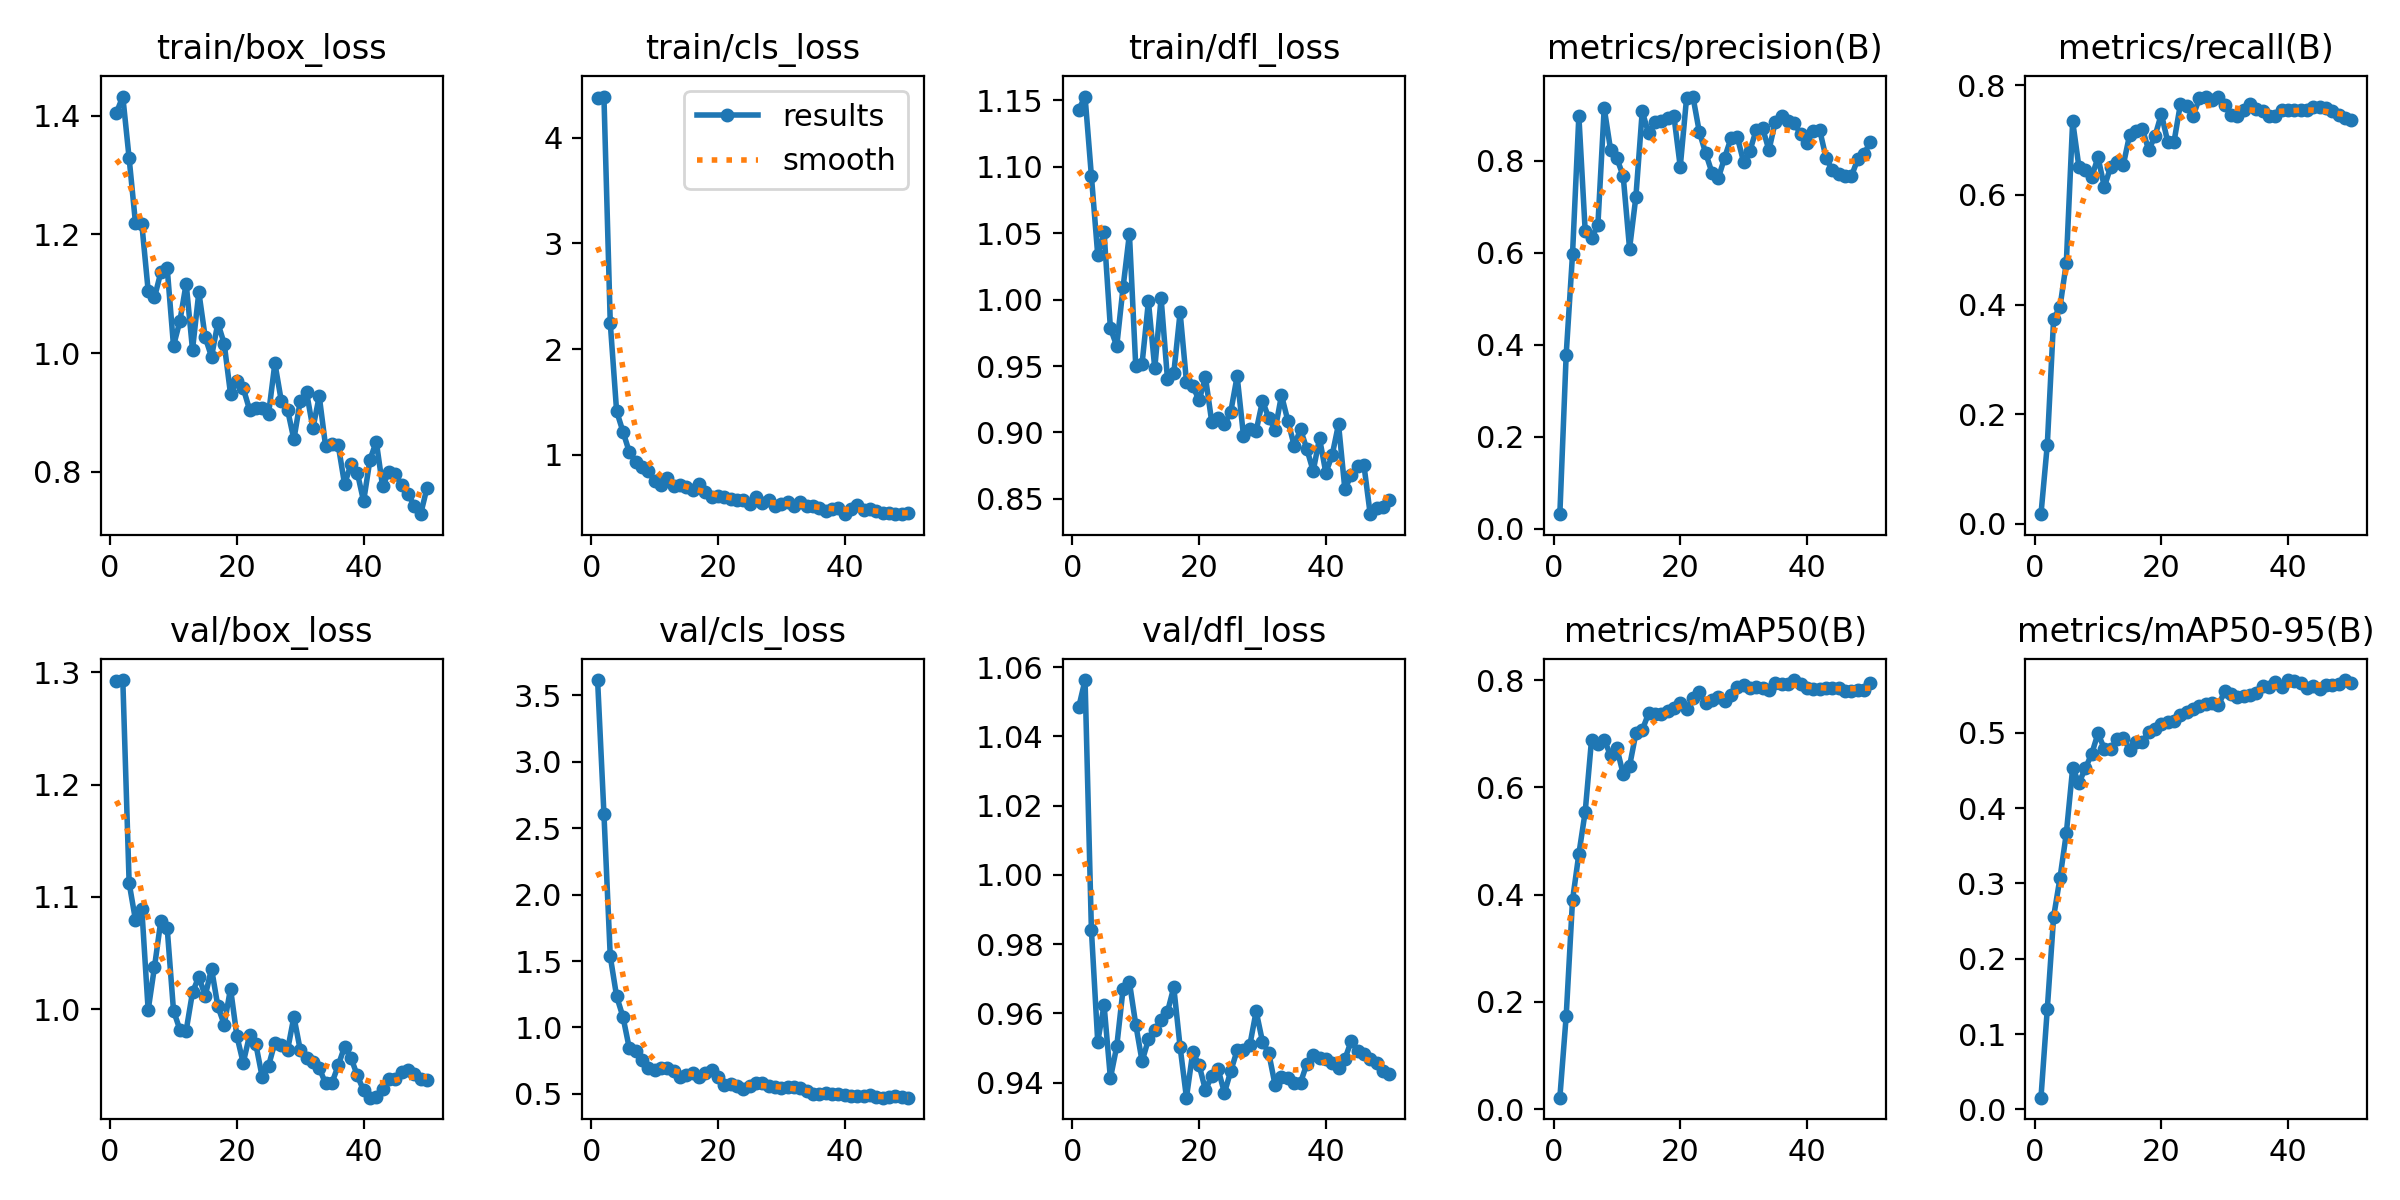

In [36]:
Display(filename='/content/runs/detect/yolov8s_no_augmentations/results.png', width=1080)

In [37]:
model_name = 'yolov8s_no_augmentations'

model = YOLO(f'runs/detect/{model_name}/weights/best.pt')

# mAP@0.5
results = model.val(data='/content/HW4/data.yaml', imgsz=640)
map50_yolov8s_no_augmentations = results.box.map50

# Prediction time on a single image
start = time.time()
results = model.predict('/content/HW4/valid/images/20240524_094101_mp4-0007_jpg.rf.4fb405f30f1a2e7dcb0fedffd08dbe87.jpg', imgsz=640)
pred_time_yolov8s_no_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1767.8±812.1 MB/s, size: 97.1 KB)
val: Scanning /content/HW4/valid/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13/13 15.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.1it/s 0.5s
                   all         13         75       0.84      0.755      0.788      0.572
                gloves          7         17      0.698      0.588      0.615        0.3
                helmet         11         20      0.977          1      0.995      0.727
             no-gloves          6         13      0.777      0.231      0.354      0.115
             no-helmet          2          2      0.774          1      0.995      0.895
                person         13         23      0.972 

# YOLO v8s with augmentations

In [39]:
start = time.time()

!yolo task=detect mode=train model=yolov8s.pt data=/content/HW4/data.yaml \
 epochs=50 imgsz=640 plots=True \
 name=yolov8s_with_augmentations \
 augment=True \
 hsv_h=0.015 hsv_s=0.4 hsv_v=0.3 \
 degrees=10 translate=0.05 scale=0.3 \
 flipud=0.0 fliplr=0.5 \
 mosaic=0.8 mixup=0.05 \
 patience=10 batch=16

train_time_yolov8s_with_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HW4/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=yolov8s_with_augmentations, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots

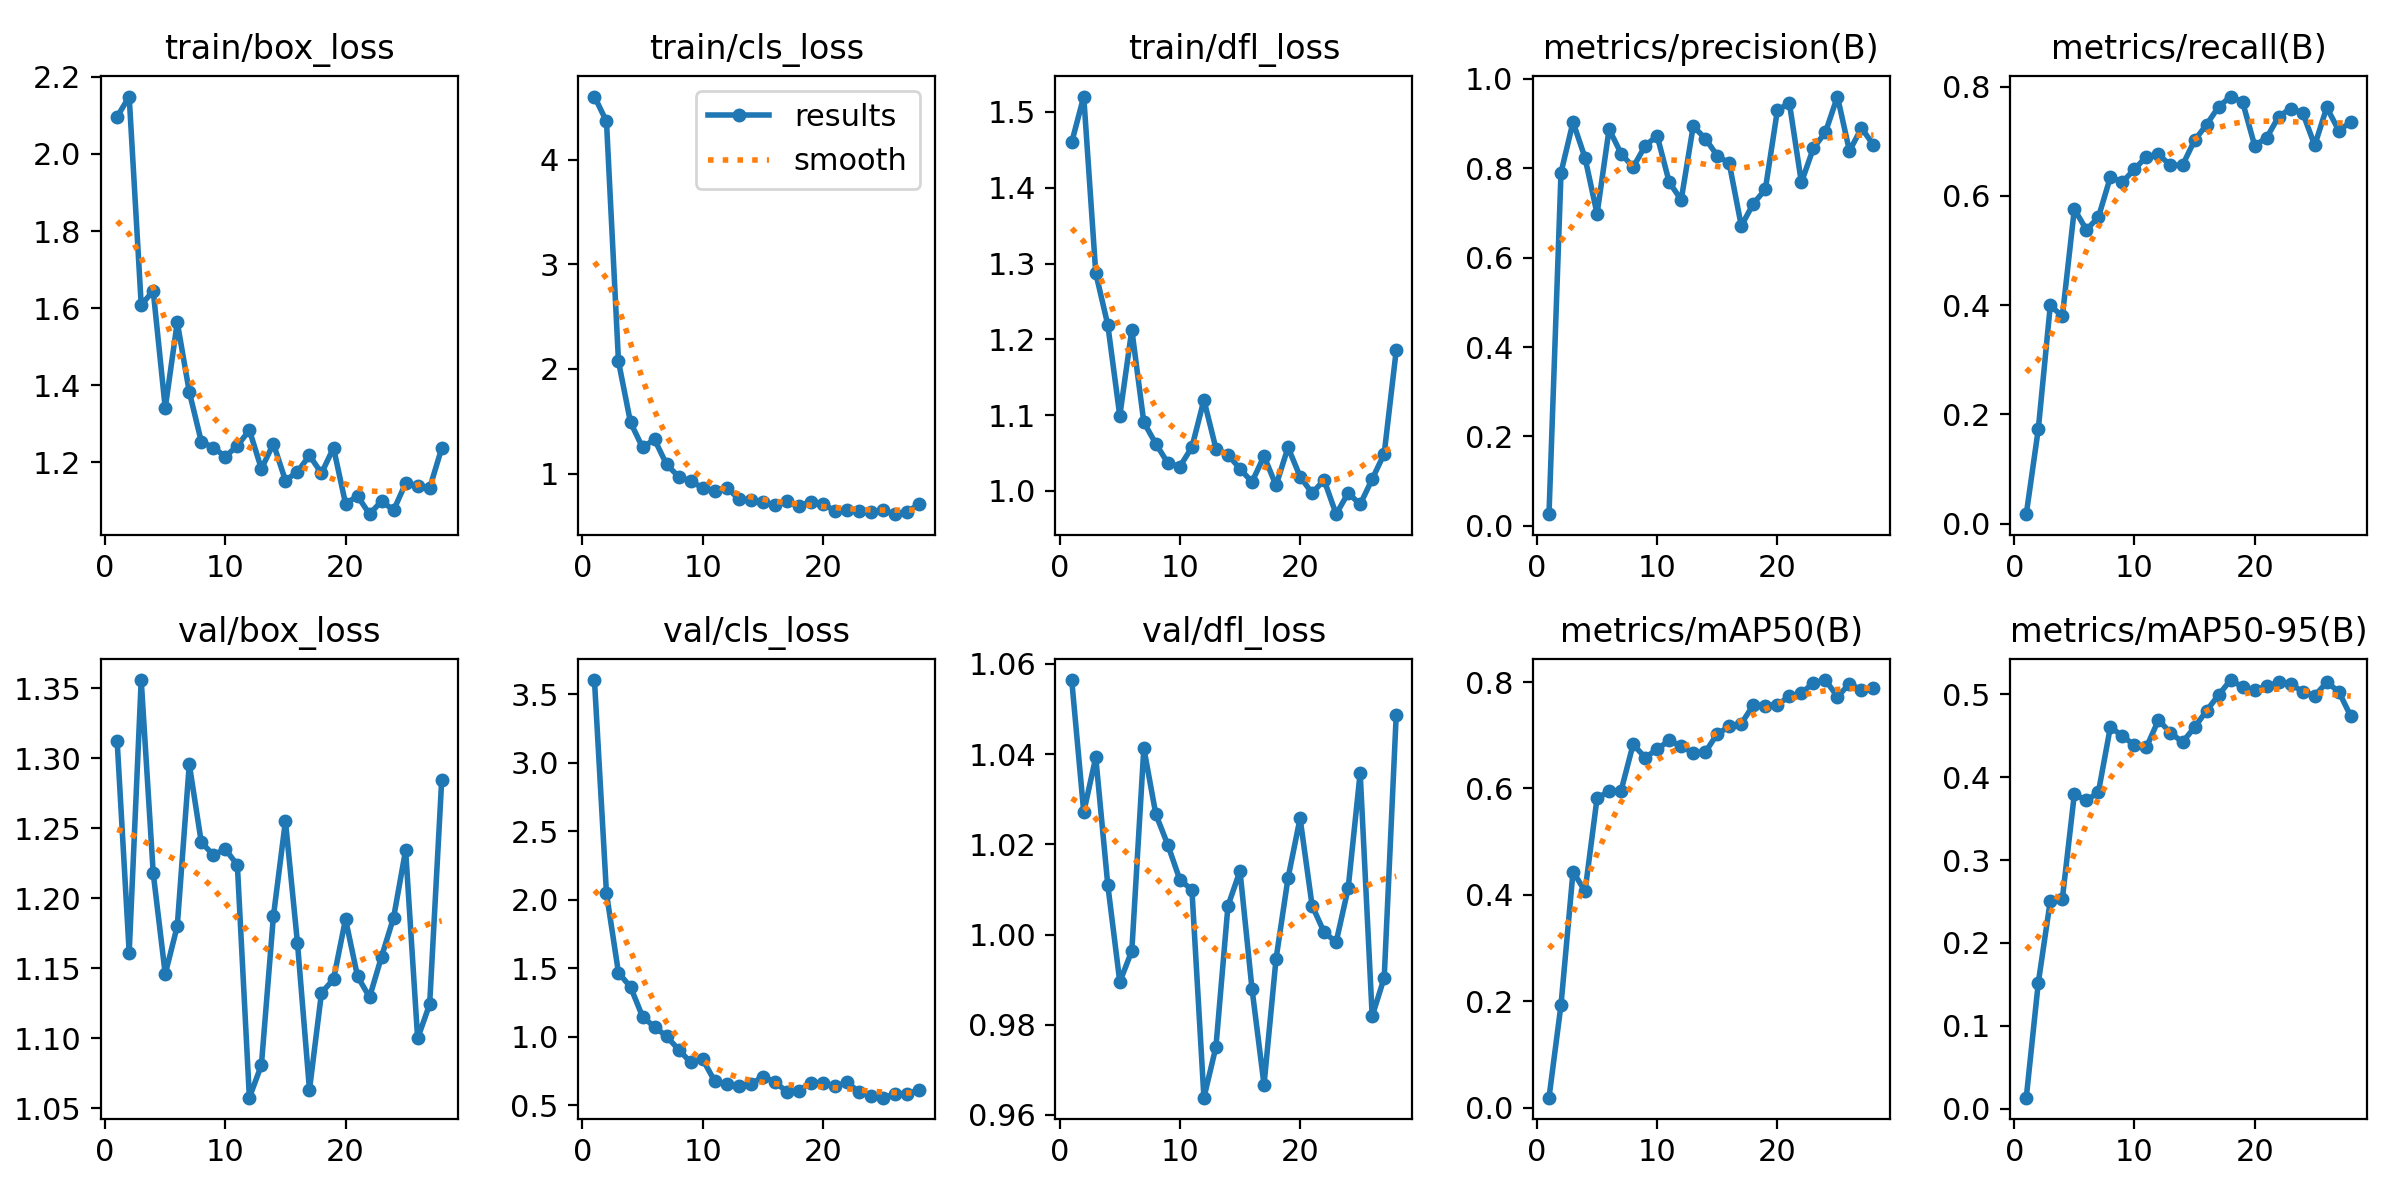

In [40]:
Display(filename='/content/runs/detect/yolov8s_with_augmentations/results.png', width=1080)

In [41]:
model_name = 'yolov8s_with_augmentations'

model = YOLO(f'runs/detect/{model_name}/weights/best.pt')

# mAP@0.5
results = model.val(data='/content/HW4/data.yaml', imgsz=640)
map50_yolov8s_with_augmentations = results.box.map50

# Prediction time on a single image
start = time.time()
results = model.predict('/content/HW4/valid/images/20240524_094101_mp4-0007_jpg.rf.4fb405f30f1a2e7dcb0fedffd08dbe87.jpg', imgsz=640)
pred_time_yolov8s_with_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2911.1±1245.6 MB/s, size: 99.5 KB)
val: Scanning /content/HW4/valid/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13/13 9.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.5it/s 0.6s
                   all         13         75      0.721      0.784      0.757      0.505
                gloves          7         17      0.383      0.693      0.573      0.231
                helmet         11         20      0.974          1      0.995      0.668
             no-gloves          6         13       0.49      0.231      0.228      0.105
             no-helmet          2          2      0.759          1      0.995      0.796
                person         13         23          1 

# YOLO v10l with augmentations

In [45]:
start = time.time()

!yolo task=detect mode=train model=yolov10l.pt data=/content/HW4/data.yaml \
 epochs=50 imgsz=640 plots=True \
 name=yolov10l_with_augmentations \
 patience=10 batch=8 \
 lr0=0.001 \
 augment=True \
 hsv_h=0.015 hsv_s=0.4 hsv_v=0.3 \
 degrees=10 translate=0.05 scale=0.3 \
 fliplr=0.5 mosaic=0.8 mixup=0.05

train_time_yolov10l_with_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HW4/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=yolov10l.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=yolov10l_with_augmentations, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plo

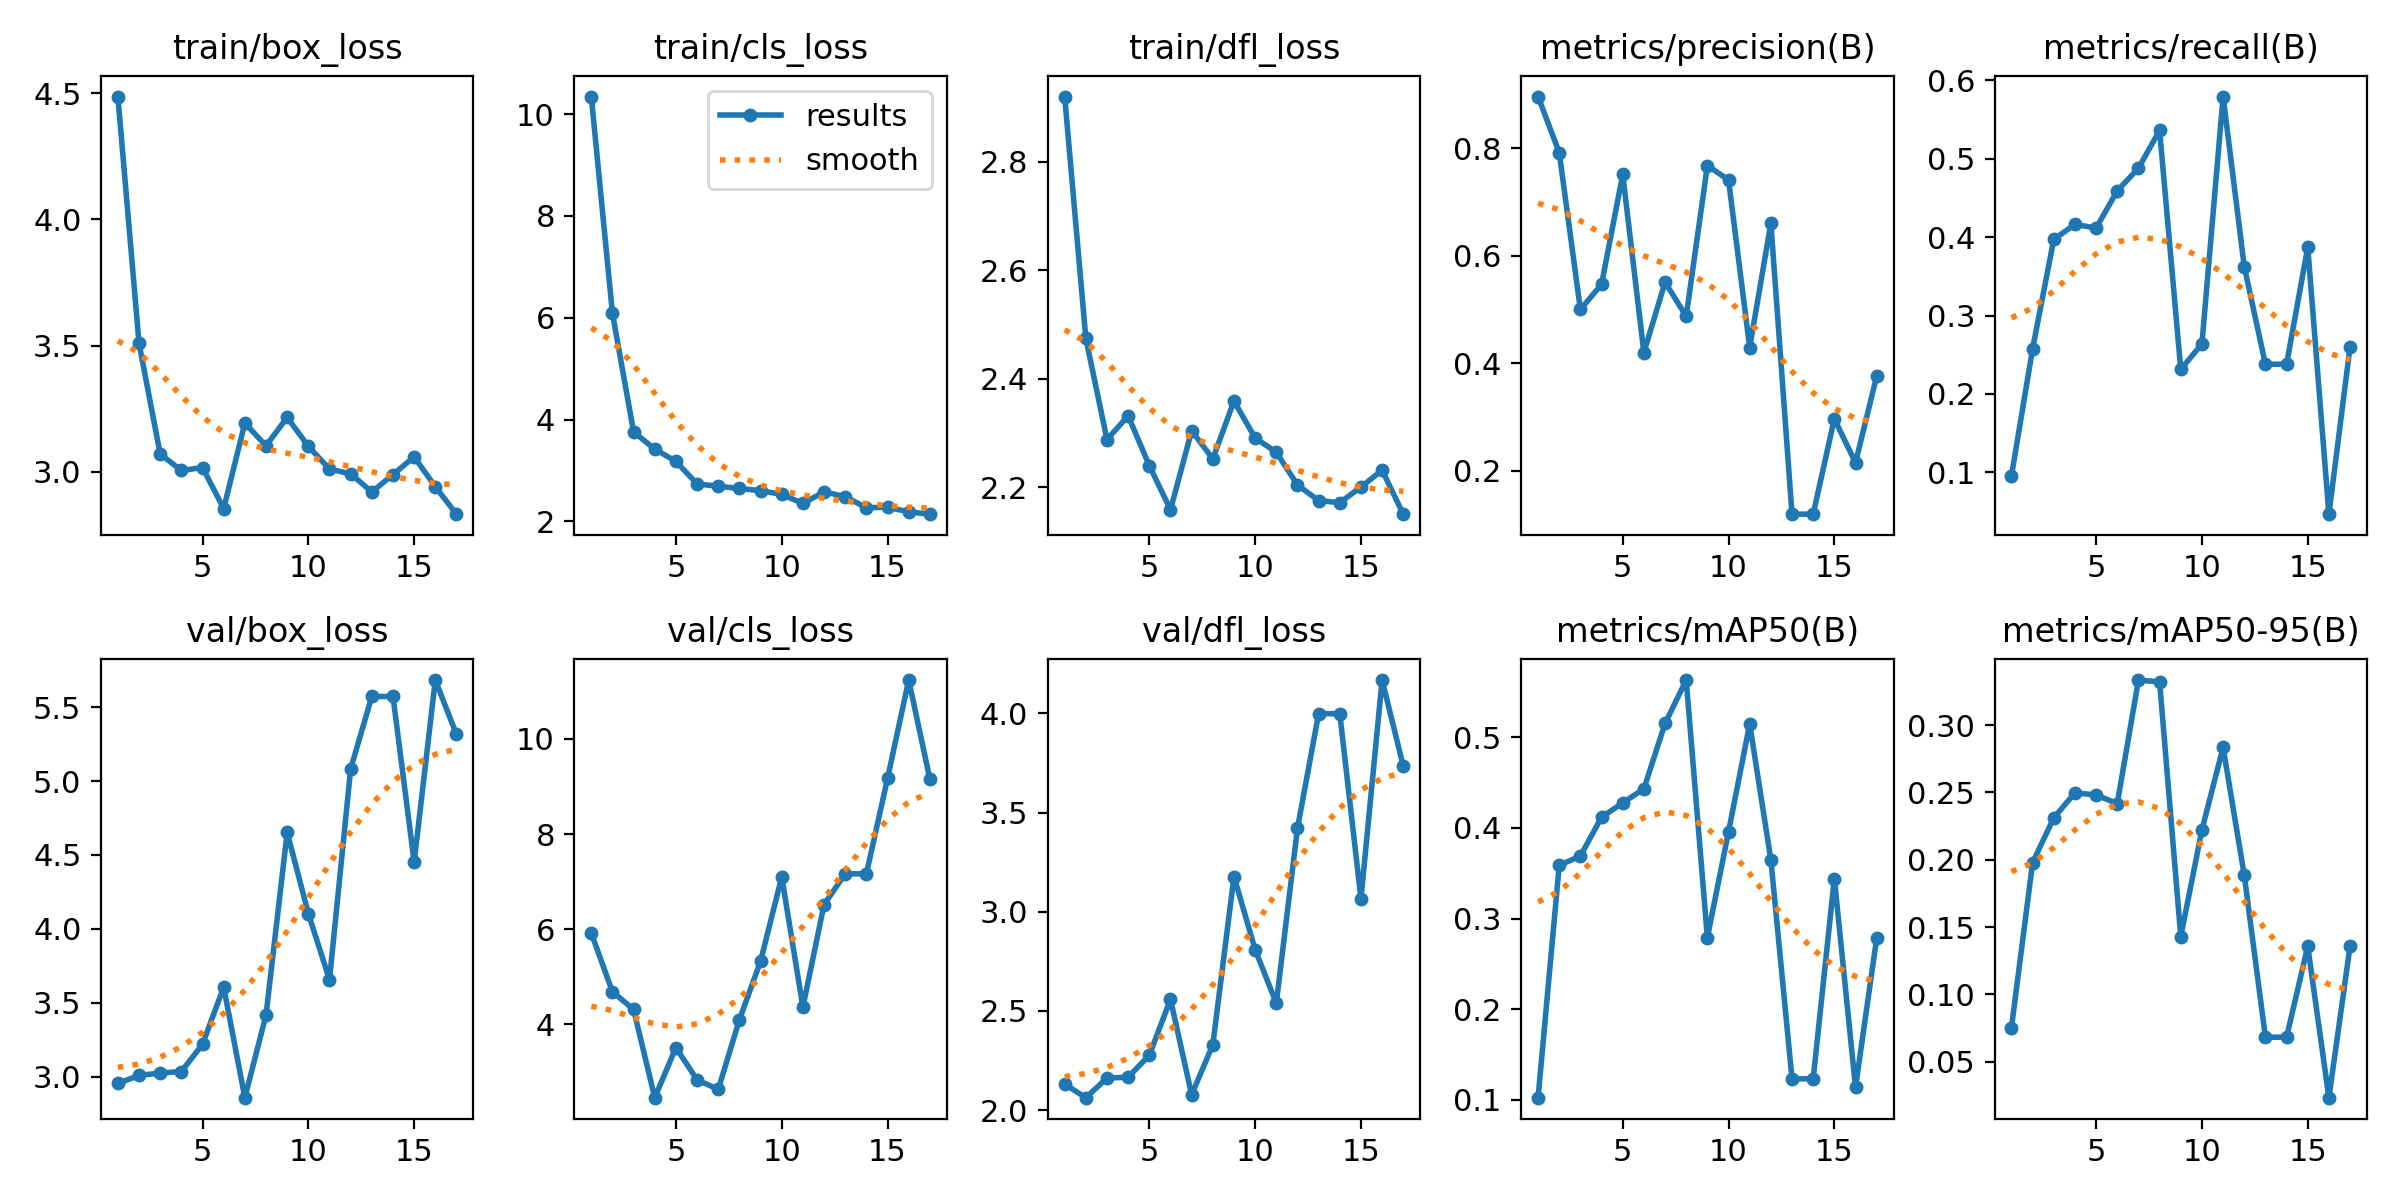

In [53]:
Display(filename='/content/runs/detect/yolov10l_with_augmentations/results.png', width=1080)

In [ ]:
model_name = 'yolov10l_with_augmentations'

model = YOLO(f'runs/detect/{model_name}/weights/best.pt')

# mAP@0.5
results = model.val(data='/content/HW4/data.yaml', imgsz=640)
map50_yolov10l_with_augmentations = results.box.map50

# Prediction time on a single image
start = time.time()
results = model.predict('/content/HW4/valid/images/20240524_094101_mp4-0007_jpg.rf.4fb405f30f1a2e7dcb0fedffd08dbe87.jpg', imgsz=640)
pred_time_yolov10l_with_augmentations = time.time() - start

# YOLO v10l without augmentations

In [55]:
start = time.time()

!yolo task=detect mode=train model=yolov10l.pt data=/content/HW4/data.yaml \
 epochs=100 imgsz=640 plots=True \
 name=yolov10l_no_augmentations \
 patience=20 batch=8 \
 lr0=0.001 \
 augment=False

train_time_yolov10l_no_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/HW4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10l_no_augmentations, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plo

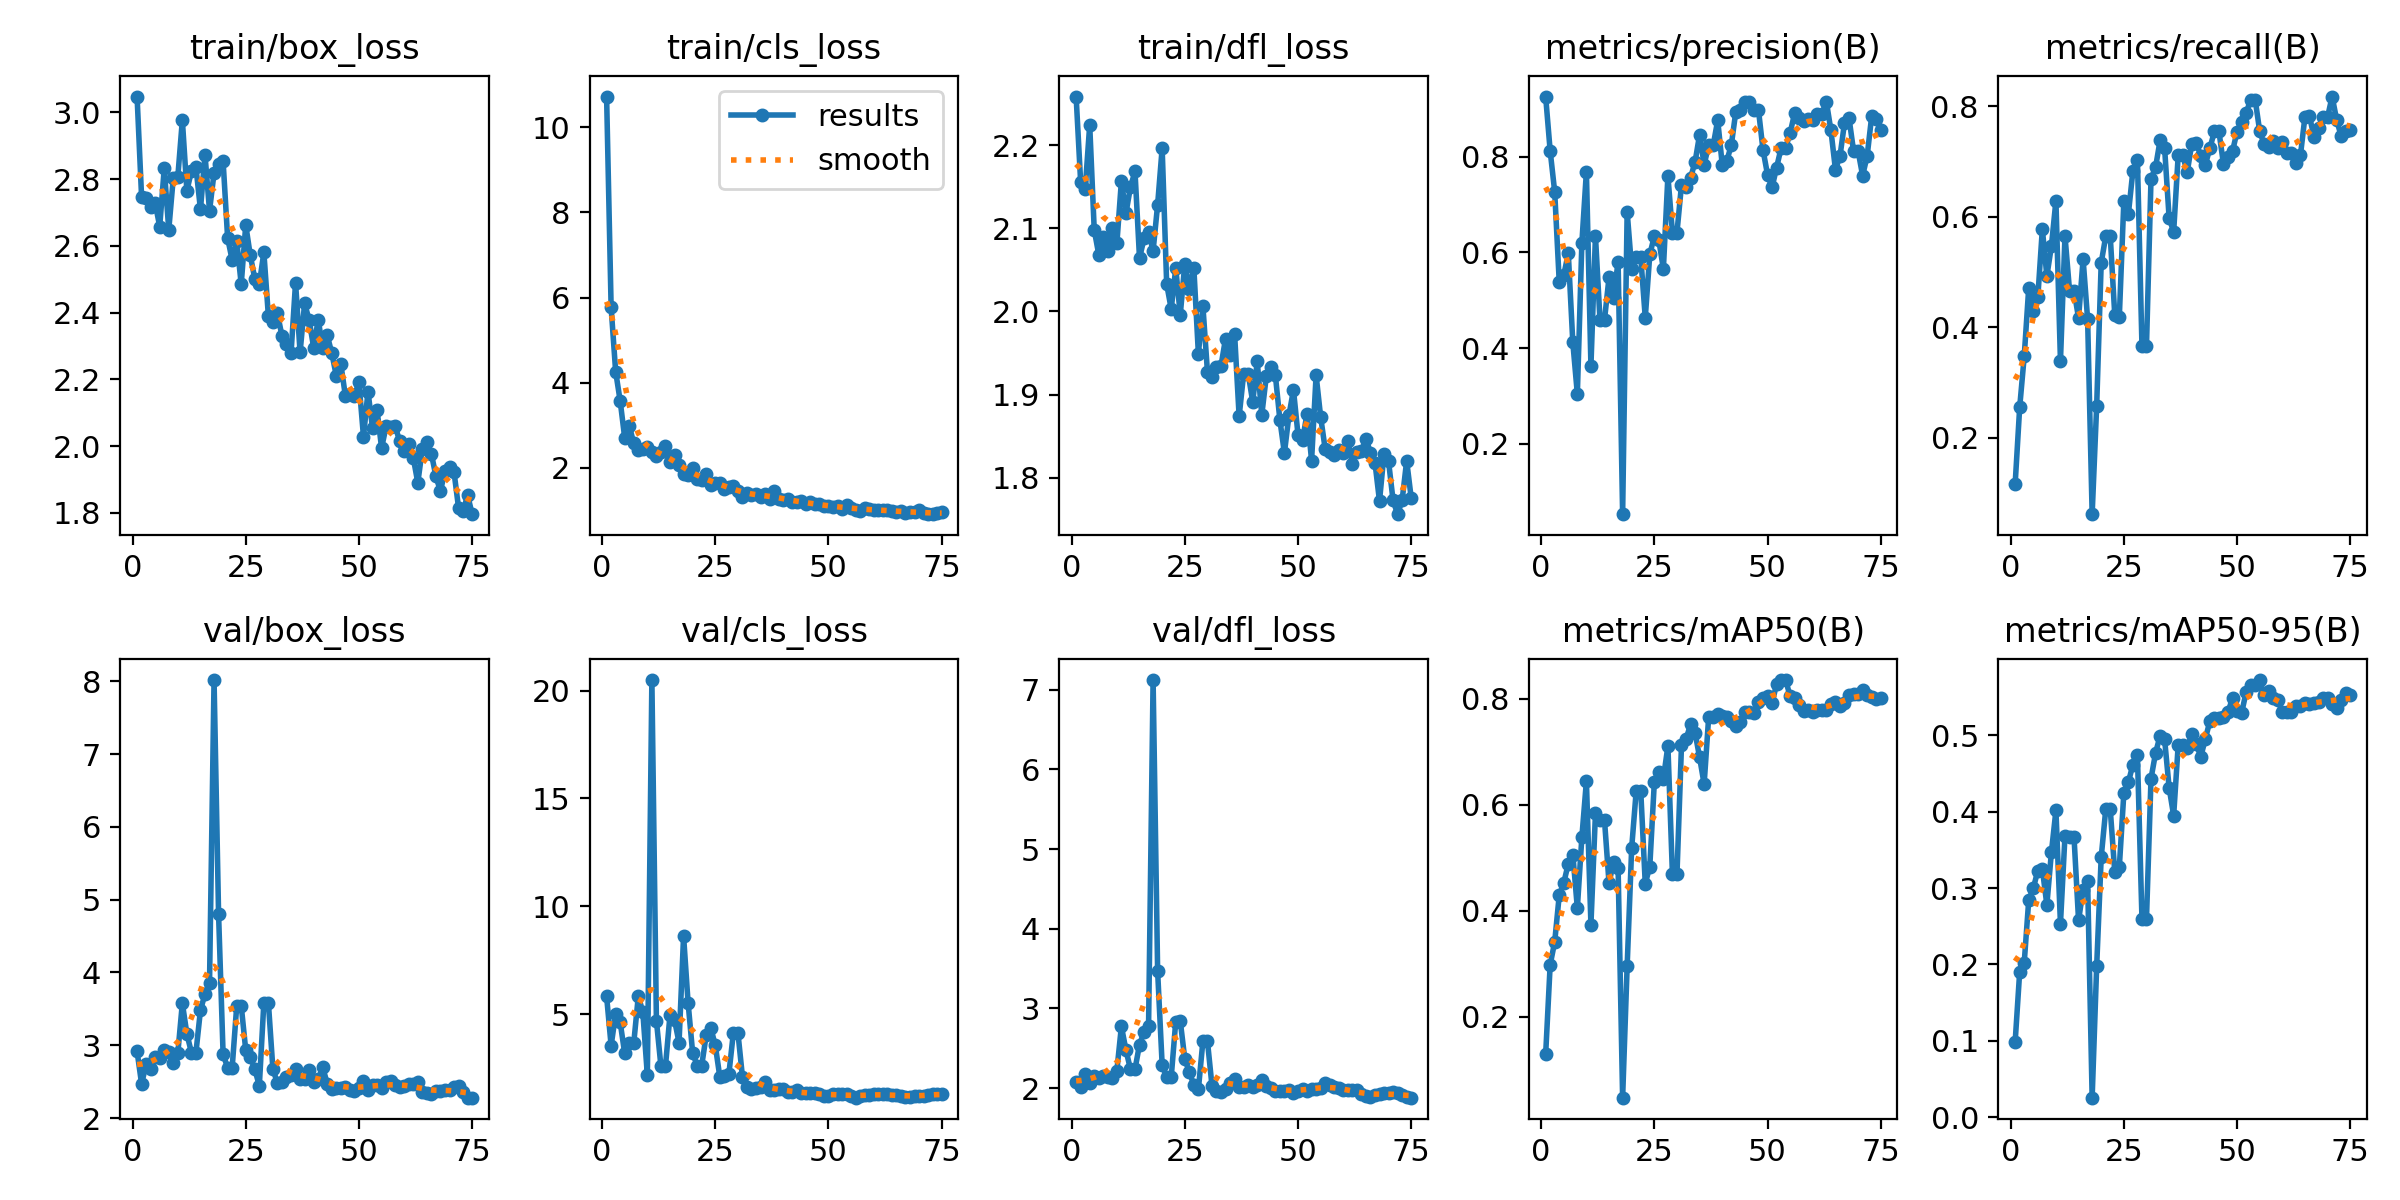

In [56]:
Display(filename='/content/runs/detect/yolov10l_no_augmentations/results.png', width=1080)

In [57]:
model_name = 'yolov10l_no_augmentations'

model = YOLO(f'runs/detect/{model_name}/weights/best.pt')

# mAP@0.5
results = model.val(data='/content/HW4/data.yaml', imgsz=640)
map50_yolov10l_no_augmentations = results.box.map50

# Prediction time on a single image
start = time.time()
results = model.predict('/content/HW4/valid/images/20240524_094101_mp4-0007_jpg.rf.4fb405f30f1a2e7dcb0fedffd08dbe87.jpg', imgsz=640)
pred_time_yolov10l_no_augmentations = time.time() - start

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10l summary (fused): 174 layers, 24,313,183 parameters, 0 gradients, 120.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2581.6±979.1 MB/s, size: 113.4 KB)
val: Scanning /content/HW4/valid/labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13/13 18.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.5it/s 0.7s
                   all         13         75       0.85      0.753      0.805      0.582
                gloves          7         17      0.776      0.647      0.677      0.374
                helmet         11         20      0.966          1      0.995      0.728
             no-gloves          6         13      0.733      0.215      0.393      0.135
             no-helmet          2          2      0.818          1      0.995      0.895
                person         13         23      

# Compare models

In [61]:
data = {
    'Model': ['YOLOv8s (no augmentations)', 'YOLOv8s (with augmentations)', 'YOLOv10l (with augmentations)', 'YOLOv10l (no augmentations)'],
    'Training Time (s)': [train_time_yolov8s_no_augmentations, train_time_yolov8s_with_augmentations, train_time_yolov10l_with_augmentations, train_time_yolov10l_no_augmentations],
    'Prediction Time (s/image)': [pred_time_yolov8s_no_augmentations, pred_time_yolov8s_with_augmentations, pred_time_yolov10l_with_augmentations, pred_time_yolov10l_no_augmentations],
    'mAP@0.5': [map50_yolov8s_no_augmentations, map50_yolov8s_with_augmentations, map50_yolov10l_with_augmentations, map50_yolov10l_no_augmentations],
}

comparison_df = pd.DataFrame(data)
comparison_df

,Model,Training Time (s),Prediction Time (s/image),mAP@0.5
0,YOLOv8s (no augmentations),113.067490,0.048926,0.787871
1,YOLOv8s (with augmentations),71.653103,0.049288,0.757244
2,YOLOv10l (with augmentations),235.242915,0.124857,0.519681
3,YOLOv10l (no augmentations),537.897650,0.120162,0.804623


# Predict on train using the best model

In [63]:
!yolo detect predict model=/content/runs/detect/yolov10l_no_augmentations/weights/best.pt conf=0.5 source=/content/20240524_094638.mp4 save_txt=True

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10l summary (fused): 174 layers, 24,313,183 parameters, 0 gradients, 120.0 GFLOPs

video 1/1 (frame 1/345) /content/20240524_094638.mp4: 384x640 (no detections), 50.5ms
video 1/1 (frame 2/345) /content/20240524_094638.mp4: 384x640 (no detections), 33.4ms
video 1/1 (frame 3/345) /content/20240524_094638.mp4: 384x640 (no detections), 33.4ms
video 1/1 (frame 4/345) /content/20240524_094638.mp4: 384x640 (no detections), 33.4ms
video 1/1 (frame 5/345) /content/20240524_094638.mp4: 384x640 (no detections), 33.5ms
video 1/1 (frame 6/345) /content/20240524_094638.mp4: 384x640 (no detections), 33.4ms
video 1/1 (frame 7/345) /content/20240524_094638.mp4: 384x640 (no detections), 32.8ms
video 1/1 (frame 8/345) /content/20240524_094638.mp4: 384x640 (no detections), 25.2ms
video 1/1 (frame 9/345) /content/20240524_094638.mp4: 384x640 (no detections), 25.2ms
video 1/1 (frame 10/345) /content/20240524_094638.mp4: 

In [64]:
!yolo detect predict model=/content/runs/detect/yolov10l_no_augmentations/weights/best.pt conf=0.5 source=/content/video_2024-05-27_12-54-54.mp4 save_txt=True

Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10l summary (fused): 174 layers, 24,313,183 parameters, 0 gradients, 120.0 GFLOPs

video 1/1 (frame 1/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 50.6ms
video 1/1 (frame 2/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 33.3ms
video 1/1 (frame 3/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 33.2ms
video 1/1 (frame 4/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 27.5ms
video 1/1 (frame 5/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 27.5ms
video 1/1 (frame 6/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 27.6ms
video 1/1 (frame 7/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 27.5ms
video 1/1 (frame 8/451) /content/video_2024-05-27_12-54-54.mp4: 384x640 (no detections), 28.2ms
video 1/1 (frame 9/451) /content/video_2024-05-27_12-54-54.mp

# Violations

In [113]:
CLASS_NAMES = class_names
VIOLATION_CLASSES = {2: 'no-gloves', 3: 'no-helmet'}


VIDEO_INFO = {
    'video1': {
        'path': '/content/20240524_094638.mp4',
        'model': 'yolov10l',
        'augment': False,
        'predict_dir': 'runs/detect/predict'
    },
    'video2': {
        'path': '/content/video_2024-05-27_12-54-54.mp4',
        'model': 'yolov10l',
        'augment': False,
        'predict_dir': 'runs/detect/predict2'
    }
}

In [122]:
def load_yolo_results(predict_dir):
    results_dict = {}

    labels_dir = os.path.join(predict_dir, 'labels')

    if os.path.exists(labels_dir):
        for txt_file in sorted(os.listdir(labels_dir)):
            if txt_file.endswith('.txt'):
                parts = txt_file.replace('.txt', '').split('_')
                try:
                    frame_num = int(parts[-1])
                    frame_name = '_'.join(parts[:-1])
                except ValueError:
                    print(f"Warning: Could not extract integer frame number from {txt_file}. Skipping.")
                    continue


                txt_path = os.path.join(labels_dir, txt_file)

                predictions = []
                with open(txt_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])
                            conf = float(parts[5]) if len(parts) > 5 else 1.0
                            predictions.append({
                                'class_id': class_id,
                                'x_center': x_center,
                                'y_center': y_center,
                                'width': width,
                                'height': height,
                                'conf': conf
                            })
                results_dict[frame_num] = predictions

    return results_dict

def denormalize_coords(pred, img_width, img_height):
    """Convert normalized YOLO coordinates to pixel coordinates"""
    x_center = pred['x_center'] * img_width
    y_center = pred['y_center'] * img_height
    width = pred['width'] * img_width
    height = pred['height'] * img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    return x1, y1, x2, y2

def detect_violations(frame_predictions, min_consecutive=3):
    """
    Detect violations: person + (no-helmet OR no-gloves) for at least min_consecutive frames
    """
    violation_list = []

    for frame_num in sorted(frame_predictions.keys()):
        preds = frame_predictions[frame_num]

        has_person = any(p['class_id'] == 4 for p in preds)

        if has_person:
            for pred in preds:
                if pred['class_id'] in VIOLATION_CLASSES:
                    violation_list.append({
                        'frame': frame_num,
                        'frame_num': frame_num,
                        'violation_class': CLASS_NAMES[pred['class_id']],
                        'conf': pred['conf'],
                        'pred': pred
                    })


    if not violation_list:
        return []

    violations_by_class = defaultdict(list)
    for v in violation_list:
        violations_by_class[v['violation_class']].append(v)

    filtered_violations = []
    for violation_class, violations in violations_by_class.items():
        violations = sorted(violations, key=lambda x: x['frame_num'])

        i = 0
        while i <= len(violations) - min_consecutive:
            consecutive = True
            for j in range(min_consecutive - 1):
                if violations[i + j + 1]['frame_num'] - violations[i + j]['frame_num'] != 1:
                    consecutive = False
                    break

            if consecutive:
                for j in range(min_consecutive):
                    filtered_violations.append(violations[i + j])
                i += min_consecutive
            else:
                i += 1

    return filtered_violations

def create_violation_report(video_name, video_path, predict_dir):

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video: {video_path}")
    print(f"FPS: {fps}, Width: {width}, Height: {height}, Frames: {frame_count}")

    frame_predictions = load_yolo_results(predict_dir)
    print(f"Loaded predictions for {len(frame_predictions)} frames")

    violations = detect_violations(frame_predictions, min_consecutive=3)
    print(f"Found {len(violations)} violation detections (after filtering)")

    report_data = []
    for v in violations:
        frame_num = v['frame_num']
        time_sec = frame_num / fps
        violation_class = v['violation_class']
        conf = v['conf']
        pred = v['pred']

        x1, y1, x2, y2 = denormalize_coords(pred, width, height)

        report_data.append({
            'video': video_name,
            'frame': frame_num,
            'time_sec': f'{time_sec:.2f}',
            'violation_class': violation_class,
            'conf': f'{conf:.3f}',
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2
        })

    df = pd.DataFrame(report_data)

    cap.release()
    return df, frame_predictions, fps, width, height

In [136]:
all_violations_df = pd.DataFrame()

for video_name, video_info in VIDEO_INFO.items():
    print(f"\n{'='*60}")
    print(f"Processing {video_name}...")
    print(f"{'='*60}")

    video_path = video_info['path']
    predict_dir = video_info['predict_dir']

    violation_df, frame_predictions, fps, width, height = create_violation_report(
        video_name, video_path, predict_dir
    )

    if not violation_df.empty:
        print(f"Found {len(violation_df)} violation frames in {video_name}")
        violation_df['video'] = video_name
        all_violations_df = pd.concat([all_violations_df, violation_df], ignore_index=True)
    else:
        print(f"No violations detected in {video_name}")


Processing video1...
Video: /content/20240524_094638.mp4
FPS: 30.03374806666815, Width: 1920, Height: 1080, Frames: 345
Loaded predictions for 266 frames
Found 69 violation detections (after filtering)
Found 69 violation frames in video1

Processing video2...
Video: /content/video_2024-05-27_12-54-54.mp4
FPS: 30.009914583753833, Width: 1280, Height: 720, Frames: 451
Loaded predictions for 412 frames
Found 48 violation detections (after filtering)
Found 48 violation frames in video2


In [137]:
all_violations_df.head()

,video,frame,time_sec,violation_class,conf,x1,y1,x2,y2
0,video1,166,5.53,no-gloves,1.000,1407,719,1431,756
1,video1,167,5.56,no-gloves,1.000,1370,781,1416,839
2,video1,168,5.59,no-gloves,1.000,1364,781,1413,841
3,video1,170,5.66,no-gloves,1.000,1342,783,1394,848
4,video1,171,5.69,no-gloves,1.000,1326,784,1386,848


In [139]:
all_violations_df['video'].value_counts()

,count
video,
video1,69
video2,48


In [154]:
all_violations_df['conf'].value_counts()

,count
conf,
1.000,117


# Plot violations

In [149]:
import random

unique_videos = all_violations_df['video'].unique().tolist()
video_violation_frames = {}

for video in unique_videos:
    video_df = all_violations_df[all_violations_df['video'] == video]
    unique_frames = video_df['frame'].unique().tolist()
    num_frames_to_select = min(2, len(unique_frames))
    selected_frames = random.sample(unique_frames, num_frames_to_select)
    video_violation_frames[video] = selected_frames

print(video_violation_frames)

{'video1': [289, 207], 'video2': [217, 153]}


In [151]:
violation_data_for_plotting = {}

for video_name, frame_numbers in video_violation_frames.items():
    video_violations = all_violations_df[all_violations_df['video'] == video_name]
    frame_violations = {}
    for frame_num in frame_numbers:
        violations_in_frame = video_violations[video_violations['frame'] == frame_num]
        violation_list = []
        for index, row in violations_in_frame.iterrows():
            violation_list.append({
                'class_name': row['violation_class'],
                'conf': row['conf'],
                'bbox': (row['x1'], row['y1'], row['x2'], row['y2'])
            })
        frame_violations[frame_num] = violation_list
    violation_data_for_plotting[video_name] = frame_violations

print(violation_data_for_plotting)

{'video1': {289: [{'class_name': 'no-gloves', 'conf': '1.000', 'bbox': (188, 500, 214, 534)}], 207: [{'class_name': 'no-gloves', 'conf': '1.000', 'bbox': (519, 351, 568, 426)}]}, 'video2': {217: [{'class_name': 'no-gloves', 'conf': '1.000', 'bbox': (527, 376, 546, 399)}], 153: [{'class_name': 'no-gloves', 'conf': '1.000', 'bbox': (353, 304, 365, 326)}]}}


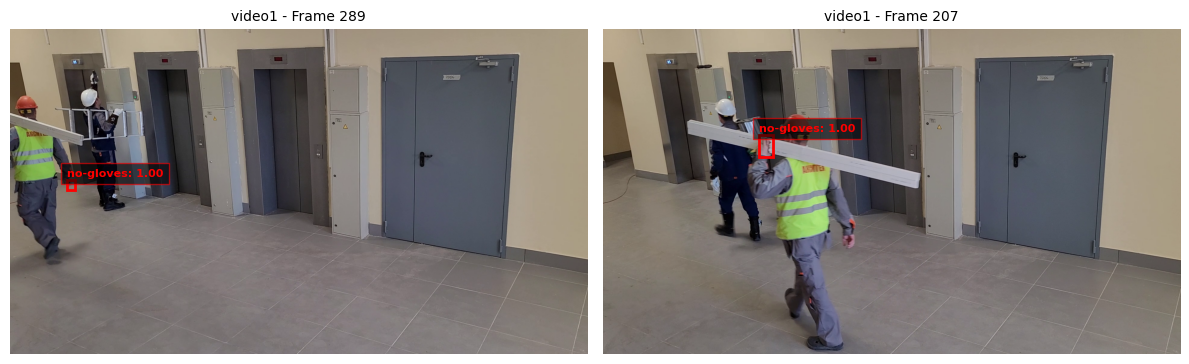

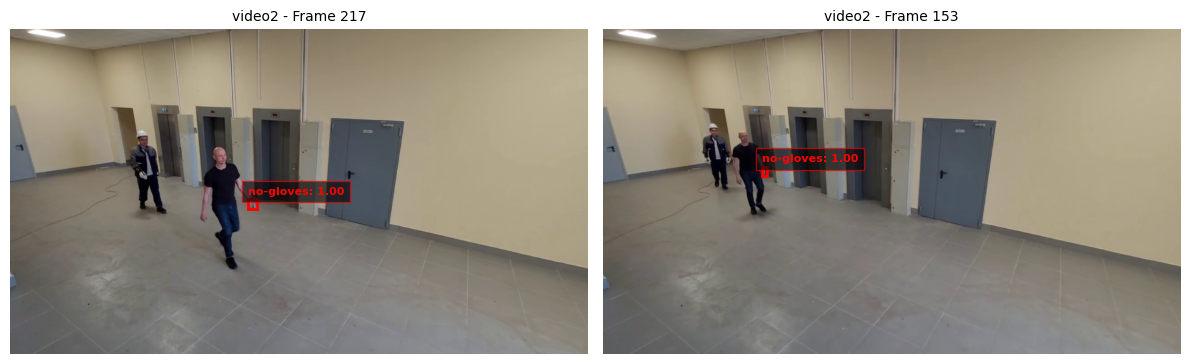

In [152]:
import matplotlib.patches as patches
import matplotlib.cm as cm

for video_name, frame_numbers in video_violation_frames.items():
    num_frames = len(frame_numbers)
    fig, axes = plt.subplots(1, num_frames, figsize=(6 * num_frames, 6))
    if num_frames == 1:
        axes = [axes]

    for idx, frame_num in enumerate(frame_numbers):
        frame_image = loaded_frames[video_name][frame_num]
        ax = axes[idx]
        ax.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
        ax.set_title(f'{video_name} - Frame {frame_num}', fontsize=10)
        ax.axis('off')

        if frame_num in violation_data_for_plotting[video_name]:
            violations = violation_data_for_plotting[video_name][frame_num]
            for violation in violations:
                x1, y1, x2, y2 = violation['bbox']
                violation_class = violation['class_name']
                conf = float(violation['conf'])

                color = 'red'

                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                        linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                label_text = f'{violation_class}: {conf:.2f}'
                ax.text(x1, y1 - 10, label_text, color=color, fontsize=8, fontweight='bold',
                       bbox=dict(facecolor='black', alpha=0.6, edgecolor=color))

    plt.tight_layout()
    plt.show()

# Conclusion

Сравнение моделей (таблица с результатами находится в блокноте выше, сразу после тренировки моделей в разделе "Compare models"):
* По точности (mAP@0.5): лучшая модель YOLOv10l без аугментаций — 80.46%
* По скорости обучения: YOLOv8s c аугментациями — 71.65 сек, но у нее было меньше эпох, чему у такой же модели, но без аугментаци
* По скорости инференса: YOLOv8s — 0.049 мс/изображение
* Для реал тайм предсказаний: YOLOv8s может обработать около 20 кадров/сек, YOLOv10l только около 8
* YOLOv8s победит, если нужна скорость. YOLOv10l точнее, но требует серьезных вычислительных ресурсов.
* Что следует доработки - несмотря на то, что для предсказаний выбрано conf=0.5, в таблице с наружениями conf=1, следует доработать этот момент.